In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [3]:
def dicky_fuller(df):
    i = 0
    dftest = adfuller(np.diff(df,i), autolag='AIC')
    test_stat = dftest[0]
    critical_val_5 = dftest[4]['5%']
    while test_stat > critical_val_5:
        i+=1
        dftest = adfuller(np.diff(df,i), autolag='AIC')
        test_stat = dftest[0]
        critical_val_5 = dftest[4]['5%']
    return(i)

In [4]:
df_lf = pd.read_csv('../../src/data/df_lf_arima.csv', index_col='time', parse_dates=['time'])
# df_lf.head()

In [5]:
zipcodes = [37115, 37148, 37221, 37174, 37210]

shape of train and test datasets: (61,) (15,) 



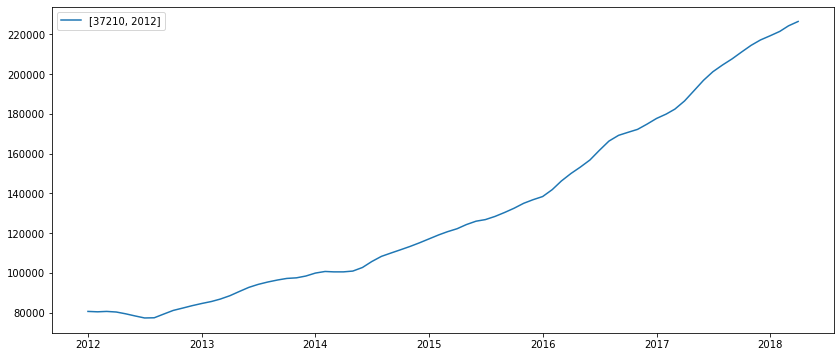

In [6]:
zip_code = zipcodes[4]    # change these params
start_year = 2012   # change these params (1996, 2010 or 2012)
eoti_percent = .8

df_zip_code = df_lf[(df_lf.RegionName== zip_code) & (df_lf.index.year >= start_year)]

eoti = round(df_zip_code.shape[0] * eoti_percent)
df_zip_code_train = df_zip_code.value[:eoti]
df_zip_code_test = df_zip_code.value[eoti:]

print("shape of train and test datasets:", df_zip_code_train.shape, df_zip_code_test.shape, '\n')

plt.subplots(figsize = (14,6))
plt.plot(df_zip_code.value, label=[zip_code,start_year])
plt.legend(loc='best');

# ARIMA

## d

In [7]:
dicky_fuller(df_zip_code_train)

# order of differencing

2

## p, q

/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


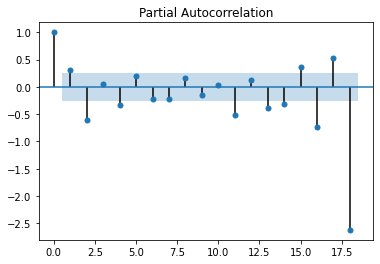

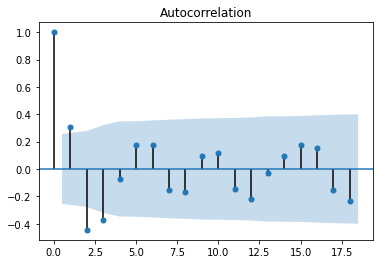

In [28]:
i = dicky_fuller(df_zip_code_train)

plot_pacf(np.diff(df_zip_code_train,i)); #ar

plot_acf(np.diff(df_zip_code_train,i)); #ma

# looks like 0,2,0 are the best params, at i = 2, 
# but they won't work with ARIMA.

In [10]:
# Let's check auto_arima for suggestions, shall we:

auto_arima(df_zip_code_train, start_p=0, d=i, start_q=0, max_p=5, max_q=5, seasonal=False, trace=True)

# NOTE: from the SARIMA model below, 2,2,2 gave better aic. Got better results with ARIMA too.
# But auto_arima didn't even check for it here...

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=945.748, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=947.755, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=947.749, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=944.073, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=949.737, Time=0.10 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.227 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, with_intercept=False)

## Modeling (ARIMA)

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   59
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -453.720
Method:                       css-mle   S.D. of innovations            523.599
Date:                Thu, 12 Nov 2020   AIC                            917.441
Time:                        19:36:57   BIC                            927.829
Sample:                    03-01-2012   HQIC                           921.496
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             47.3181     79.041      0.599      0.549    -107.600     202.236
ar.L1.D2.value     0.1641      0.162      1.016      0.310      -0.153       0.481
ar.L2.D2.value    -0.4804      0.132

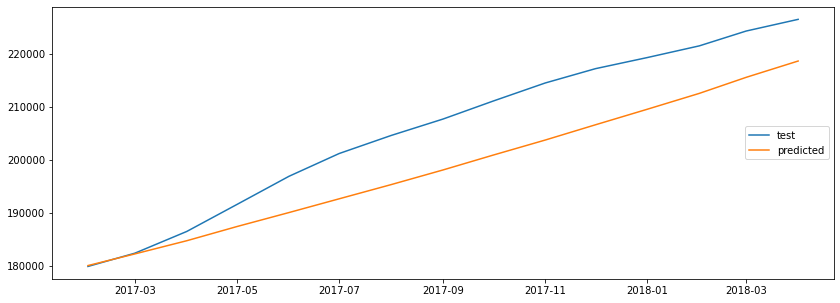

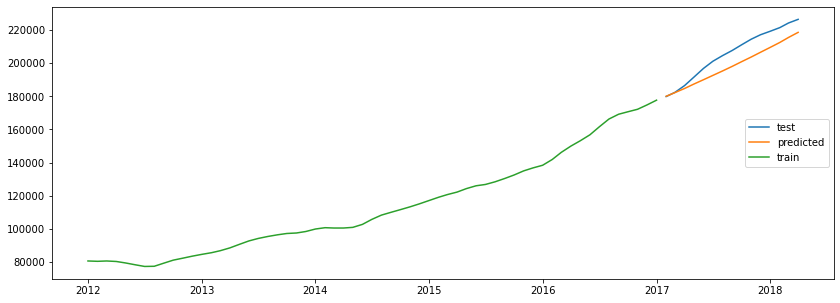

In [23]:
ar, i, ma = [2,2,1] # change these params

model = ARIMA(df_zip_code_train, (ar,i,ma), freq='MS').fit()
y_hat_model = model.predict(typ='levels')
rmse_model = np.sqrt(mean_squared_error(df_zip_code_train[i:], y_hat_model))

test_start_dt = df_zip_code_test.index[0]
test_end_dt = df_zip_code_test.index[-1]
y_hat_model_test = model.predict(start=test_start_dt, end=test_end_dt, typ='levels')
rmse_model_test = np.sqrt(mean_squared_error(df_zip_code_test, y_hat_model_test))

print(model.summary(), '\n')
print('train rmse:', rmse_model, '\n')
print('test rmse:', rmse_model_test, '\n')
print('train aic:', model.aic, '\n')

fig, ax2 = plt.subplots(figsize=(14,5))
ax2.plot(df_zip_code_test, label='test')
ax2.plot(y_hat_model_test, label='predicted')
ax2.legend(loc="right")

fig, ax1 = plt.subplots(figsize=(14,5))
ax1.plot(df_zip_code_test, label='test')
ax1.plot(y_hat_model_test, label='predicted')
ax1.plot(df_zip_code_train, label='train')
ax1.legend(loc="right");

# SARIMAX

In [11]:
import itertools

i = dicky_fuller(df_zip_code_train)

p = q = range(0, 4)
pdq = list(itertools.product(p, [i], q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 2, 0) x (0, 1, 0, 12)
SARIMAX: (0, 2, 0) x (0, 1, 1, 12)
SARIMAX: (0, 2, 0) x (0, 1, 2, 12)
SARIMAX: (0, 2, 0) x (1, 1, 0, 12)
SARIMAX: (0, 2, 0) x (1, 1, 1, 12)
SARIMAX: (0, 2, 0) x (1, 1, 2, 12)
SARIMAX: (0, 2, 0) x (2, 1, 0, 12)
SARIMAX: (0, 2, 0) x (2, 1, 1, 12)
SARIMAX: (0, 2, 0) x (2, 1, 2, 12)
SARIMAX: (0, 2, 1) x (0, 1, 0, 12)
SARIMAX: (0, 2, 1) x (0, 1, 1, 12)
SARIMAX: (0, 2, 1) x (0, 1, 2, 12)
SARIMAX: (0, 2, 1) x (1, 1, 0, 12)
SARIMAX: (0, 2, 1) x (1, 1, 1, 12)
SARIMAX: (0, 2, 1) x (1, 1, 2, 12)
SARIMAX: (0, 2, 1) x (2, 1, 0, 12)
SARIMAX: (0, 2, 1) x (2, 1, 1, 12)
SARIMAX: (0, 2, 1) x (2, 1, 2, 12)
SARIMAX: (0, 2, 2) x (0, 1, 0, 12)
SARIMAX: (0, 2, 2) x (0, 1, 1, 12)
SARIMAX: (0, 2, 2) x (0, 1, 2, 12)
SARIMAX: (0, 2, 2) x (1, 1, 0, 12)
SARIMAX: (0, 2, 2) x (1, 1, 1, 12)
SARIMAX: (0, 2, 2) x (1, 1, 2, 12)
SARIMAX: (0, 2, 2) x (2, 1, 0, 12)
SARIMAX: (0, 2, 2) x (2, 1, 1, 12)
SARIMAX: (0, 2, 2) x (2, 1, 2, 12)
SARIMAX: (1, 2, 0) 

In [12]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =SARIMAX(df_zip_code_train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False, 
                         freq='MS')
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('hello')
            continue

/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(0, 1, 0, 12) - AIC:775.1496528100338


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 0)x(0, 1, 1, 12) - AIC:1316.240385781432
ARIMA(0, 2, 0)x(0, 1, 2, 12) - AIC:366.44515936618603
ARIMA(0, 2, 0)x(1, 1, 0, 12) - AIC:585.6632865450639


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(1, 1, 1, 12) - AIC:574.9910071434933
ARIMA(0, 2, 0)x(1, 1, 2, 12) - AIC:361.2777578201906
ARIMA(0, 2, 0)x(2, 1, 0, 12) - AIC:382.24804274468926


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(2, 1, 1, 12) - AIC:1001.8118806789897


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(2, 1, 2, 12) - AIC:361.8742609995843
ARIMA(0, 2, 1)x(0, 1, 0, 12) - AIC:750.5522889206875


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(0, 1, 1, 12) - AIC:555.086015125051
ARIMA(0, 2, 1)x(0, 1, 2, 12) - AIC:345.2975184332081
ARIMA(0, 2, 1)x(1, 1, 0, 12) - AIC:587.06063126786


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(1, 1, 1, 12) - AIC:1382.884030877
ARIMA(0, 2, 1)x(1, 1, 2, 12) - AIC:335.17569767655635


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(2, 1, 0, 12) - AIC:383.6654510752792


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(2, 1, 1, 12) - AIC:471.95729685581387


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(2, 1, 2, 12) - AIC:337.7171828266828
ARIMA(0, 2, 2)x(0, 1, 0, 12) - AIC:733.8791261669135


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(0, 1, 1, 12) - AIC:2608.5014051927487
ARIMA(0, 2, 2)x(0, 1, 2, 12) - AIC:326.2486061109598


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(1, 1, 0, 12) - AIC:585.8115170914537


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(1, 1, 1, 12) - AIC:2478.3465572452733


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(1, 1, 2, 12) - AIC:319.37695894943414


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(2, 1, 0, 12) - AIC:380.29002515508085


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(2, 1, 1, 12) - AIC:464.13301670602567


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(2, 1, 2, 12) - AIC:327.06069125264366
ARIMA(1, 2, 0)x(0, 1, 0, 12) - AIC:771.9950084769168


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(0, 1, 1, 12) - AIC:1032.990257097213
ARIMA(1, 2, 0)x(0, 1, 2, 12) - AIC:365.7209109388577
ARIMA(1, 2, 0)x(1, 1, 0, 12) - AIC:567.9477044770744


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(1, 1, 1, 12) - AIC:1370.5102193824284
ARIMA(1, 2, 0)x(1, 1, 2, 12) - AIC:367.10339357997725


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(2, 1, 0, 12) - AIC:367.8218983576609


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(2, 1, 1, 12) - AIC:972.8306184741216


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(2, 1, 2, 12) - AIC:363.9911986394511
ARIMA(1, 2, 1)x(0, 1, 0, 12) - AIC:752.0613665226988


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(0, 1, 1, 12) - AIC:1544.9140364112325
ARIMA(1, 2, 1)x(0, 1, 2, 12) - AIC:346.7114589199722


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(1, 1, 0, 12) - AIC:569.6614184111776


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(1, 1, 1, 12) - AIC:1783.8114429258655


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(1, 1, 2, 12) - AIC:335.24408574514655


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(2, 1, 0, 12) - AIC:368.88757936527054


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(2, 1, 1, 12) - AIC:665.324445577504


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(2, 1, 2, 12) - AIC:342.4960220003445
ARIMA(1, 2, 2)x(0, 1, 0, 12) - AIC:734.359173595697


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(0, 1, 1, 12) - AIC:1444.809553464053
ARIMA(1, 2, 2)x(0, 1, 2, 12) - AIC:331.7206327554827


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(1, 1, 0, 12) - AIC:562.8750597655744


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(1, 1, 1, 12) - AIC:1446.082769297598


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(1, 1, 2, 12) - AIC:321.37174188207905
ARIMA(1, 2, 2)x(2, 1, 0, 12) - AIC:363.27863595003026


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(2, 1, 1, 12) - AIC:1115.788162824434


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(2, 1, 2, 12) - AIC:327.39056706700796
ARIMA(2, 2, 0)x(0, 1, 0, 12) - AIC:738.511520892029


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(0, 1, 1, 12) - AIC:691.6916998270765
ARIMA(2, 2, 0)x(0, 1, 2, 12) - AIC:359.30349345450276
ARIMA(2, 2, 0)x(1, 1, 0, 12) - AIC:537.4428835739924


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(1, 1, 1, 12) - AIC:859.5972298000494
ARIMA(2, 2, 0)x(1, 1, 2, 12) - AIC:360.7667596768714


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(2, 1, 0, 12) - AIC:340.0287844689931


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(2, 1, 1, 12) - AIC:850.1810013399563


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(2, 1, 2, 12) - AIC:335.704385905979
ARIMA(2, 2, 1)x(0, 1, 0, 12) - AIC:740.3947714196663


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(0, 1, 1, 12) - AIC:1461.1703827330587
ARIMA(2, 2, 1)x(0, 1, 2, 12) - AIC:336.98843053033204


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(1, 1, 0, 12) - AIC:539.3131953725285


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(1, 1, 1, 12) - AIC:1349.844231509552


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(1, 1, 2, 12) - AIC:342.3816921424775
ARIMA(2, 2, 1)x(2, 1, 0, 12) - AIC:341.6276759742594


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(2, 1, 1, 12) - AIC:703.4527169222192


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(2, 1, 2, 12) - AIC:338.1413643707372
ARIMA(2, 2, 2)x(0, 1, 0, 12) - AIC:727.1982074998833


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(0, 1, 1, 12) - AIC:1425.0135035011679


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(0, 1, 2, 12) - AIC:321.0307979172161
ARIMA(2, 2, 2)x(1, 1, 0, 12) - AIC:539.5832143310172


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(1, 1, 1, 12) - AIC:784.956198521356


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(1, 1, 2, 12) - AIC:317.1561141617368
ARIMA(2, 2, 2)x(2, 1, 0, 12) - AIC:342.7565518486412


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(2, 1, 1, 12) - AIC:656.9922405377348
ARIMA(2, 2, 2)x(2, 1, 2, 12) - AIC:329.48222695957907


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                   61
Model:             SARIMAX(2, 2, 2)x(1, 1, 2, 12)   Log Likelihood                -150.578
Date:                            Thu, 12 Nov 2020   AIC                            317.156
Time:                                    19:37:30   BIC                            325.122
Sample:                                01-01-2012   HQIC                           318.711
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3268      0.455     -0.719      0.472      -1.218       0.564
ar.L2         -0.6701      0.396   

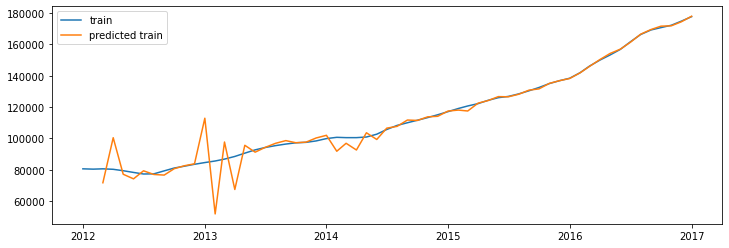

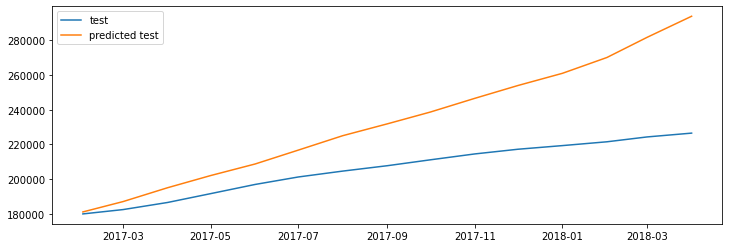

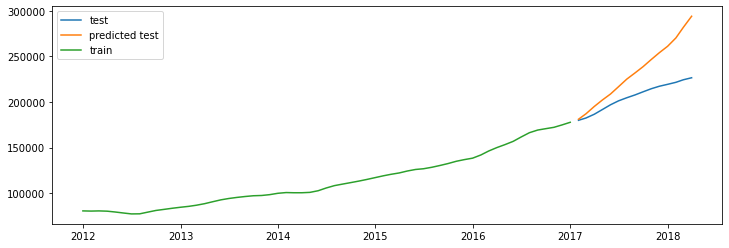

In [26]:
# ARIMA(2, 2, 2)x(1, 1, 2, 12) - AIC:317.1561141617368

p,d,q = [2,2,2]
P,D,Q,s = [1,1,2,12]

sari_mod =SARIMAX(df_zip_code_train,order=(p,d,q),
                  seasonal_order=(P,D,Q,s),
                  enforce_stationarity=False,
                  enforce_invertibility=False,
                  freq='MS').fit()

y_hat_train = sari_mod.predict(typ='levels')
# second order differencing results in the first 2 predictions of a SARIMAX being invalid basically.
# in order to address that, subset from the 3rd prediction/value onwards.
# hence the [d:] below when calculating sarimax rmse train
rmse_sarimax_train = np.sqrt(mean_squared_error(df_zip_code_train[d:], y_hat_train[d:]))

y_hat_test = sari_mod.predict(start=df_zip_code_test.index[0], end=df_zip_code_test.index[-1],typ='levels')
rmse_sarimax_test = np.sqrt(mean_squared_error(df_zip_code_test,y_hat_test))

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(df_zip_code_train, label='train')
ax1.plot(y_hat_train[d:], label='predicted train')
ax1.legend(loc='best');

fig, ax2 = plt.subplots(figsize=(12,4))
ax2.plot(df_zip_code_test, label='test')
ax2.plot(y_hat_test, label='predicted test')
ax2.legend(loc='best')

fig, ax3 = plt.subplots(figsize=(12,4))
ax3.plot(df_zip_code_test, label='test')
ax3.plot(y_hat_test, label='predicted test')
ax3.plot(df_zip_code_train, label='train')
ax3.legend(loc='best')

print(sari_mod.summary(), '\n')

print('(ARIMA) train RMSE:   ', rmse_model,)
print('(SARIMAX) train RMSE: ', rmse_sarimax_train,'\n')

print('(ARIMA) test RMSE:   ', rmse_model_test)
print('(SARIMAX) test RMSE: ', rmse_sarimax_test,'\n')

print('(ARIMA) train AIC:   ', model.aic)
print('(SARIMAX) train AIC: ', sari_mod.aic, '\n')

# Forecast

/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


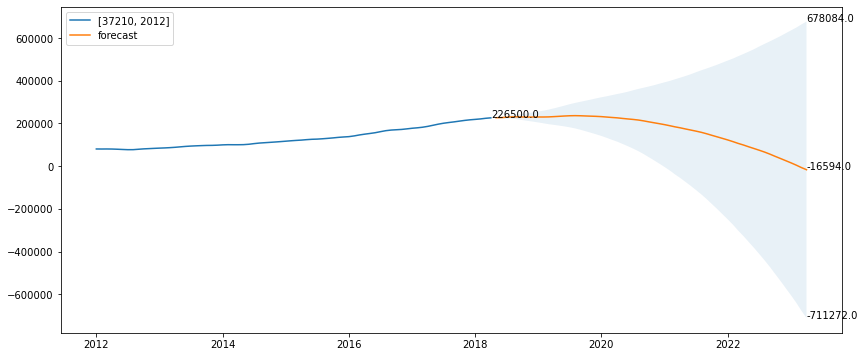

In [29]:
n = 60

sari_mod =SARIMAX(df_zip_code.value, order=(p,d,q),
                  seasonal_order=(P,D,Q,s),
                  enforce_stationarity=False,
                  enforce_invertibility=False,
                  freq='MS').fit()

forecast = sari_mod.forecast(steps = n)

get_forecast = sari_mod.get_forecast(steps=n).summary_frame()

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(df_zip_code.value, label=[zip_code,start_year])
ax.plot(forecast, label='forecast')
ax.fill_between(get_forecast.index, get_forecast.mean_ci_lower, get_forecast.mean_ci_upper, alpha=0.1)

ax.annotate(round(df_zip_code.value[-1],0),
            (df_zip_code.index[-1], df_zip_code.value[-1]))
ax.annotate(round(get_forecast.mean_ci_upper[-1],0),
            (get_forecast.index[-1], get_forecast.mean_ci_upper[-1]))
ax.annotate(round(get_forecast['mean'][-1],0),
            (get_forecast.index[-1], get_forecast['mean'][-1]))
ax.annotate(round(get_forecast.mean_ci_lower[-1],0),
            (get_forecast.index[-1], get_forecast.mean_ci_lower[-1]))

ax.legend(loc='upper left');

In [134]:
b = df_zip_code.value[-1]
b

189800.0

In [135]:
e = forecast.values[-1]
e

349442.216535368

In [136]:
percent_diff_37115 = (e-b)/b
print('difference in percentage: ', percent_diff_37115*100)

difference in percentage:  84.11075686794942


# Conclusion: ARIMA vs Prophet (hunters model)

We're choosing Hunters model bc it has a lower RMSE, & MAPE (calculated below), for our test vs predicted data.

In [138]:
df_zip_code_test

time
2017-02-01    162100.0
2017-03-01    164200.0
2017-04-01    166000.0
2017-05-01    167200.0
2017-06-01    168700.0
2017-07-01    170800.0
2017-08-01    173000.0
2017-09-01    175600.0
2017-10-01    178100.0
2017-11-01    180000.0
2017-12-01    181700.0
2018-01-01    183900.0
2018-02-01    186000.0
2018-03-01    188300.0
2018-04-01    189800.0
Name: value, dtype: float64

In [137]:
y_hat_test

2017-02-01    162093.369182
2017-03-01    164226.805791
2017-04-01    166721.424526
2017-05-01    169416.146019
2017-06-01    171919.269202
2017-07-01    174241.309504
2017-08-01    176771.358794
2017-09-01    179334.631723
2017-10-01    181837.234763
2017-11-01    184284.124348
2017-12-01    186884.032244
2018-01-01    189673.184642
2018-02-01    192499.456913
2018-03-01    195194.912393
2018-04-01    198059.160606
Freq: MS, dtype: float64

In [130]:
MAPE = round(np.mean(np.abs(df_zip_code_test - y_hat_test)/ df_zip_code_test) * 100, 2) #mean absolute percentage error
MAPE

2.13

In [97]:
zip_code

37115